In [1]:
import pandas as pd

# Sample data for demonstration
data = {
    "open": [100, 95, 97, 96, 94, 93, 96],
    "close": [95, 97, 96, 94, 93, 96, 99],
    "high": [101, 98, 98, 97, 95, 97, 100],
    "low": [94, 94, 94, 92, 91, 92, 95]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate candle body percentage
df['body'] = abs(df['close'] - df['open'])
df['total_range'] = df['high'] - df['low']
df['body_percentage'] = (df['body'] / df['total_range']) * 100

# Determine candle type
df['candle_type'] = df['body_percentage'].apply(lambda x: 'exciting' if x > 50 else 'base')
df['color'] = df.apply(lambda row: 'red' if row['close'] < row['open'] else 'green', axis=1)

# Identify the pattern
def find_reversal_patterns(df):
    patterns = []
    i = 0

    while i < len(df) - 1:
        # Look for one or more exciting red candles
        if df.iloc[i]['candle_type'] == 'exciting' and df.iloc[i]['color'] == 'red':
            j = i + 1
            base_count = 0

            # Check for 1 to 5 base candles
            while j < len(df) and df.iloc[j]['candle_type'] == 'base' and base_count < 5:
                base_count += 1
                j += 1
            
            # Check if followed by an exciting green candle
            if j < len(df) and df.iloc[j]['candle_type'] == 'exciting' and df.iloc[j]['color'] == 'green':
                patterns.append((i, j))  # Store start and end index of the pattern
                i = j  # Move index to the end of the pattern
            else:
                i += 1
        else:
            i += 1
    
    return patterns

# Find patterns
patterns = find_reversal_patterns(df)

# Print results
if patterns:
    for start, end in patterns:
        print(f"Pattern found from index {start} to {end}")
else:
    print("No patterns found")

# Optionally filter rows to show identified patterns
for start, end in patterns:
    print(df.iloc[start:end+1])

Pattern found from index 0 to 5
   open  close  high  low  body  total_range  body_percentage candle_type  \
0   100     95   101   94     5            7        71.428571    exciting   
1    95     97    98   94     2            4        50.000000        base   
2    97     96    98   94     1            4        25.000000        base   
3    96     94    97   92     2            5        40.000000        base   
4    94     93    95   91     1            4        25.000000        base   
5    93     96    97   92     3            5        60.000000    exciting   

   color  
0    red  
1  green  
2    red  
3    red  
4    red  
5  green  


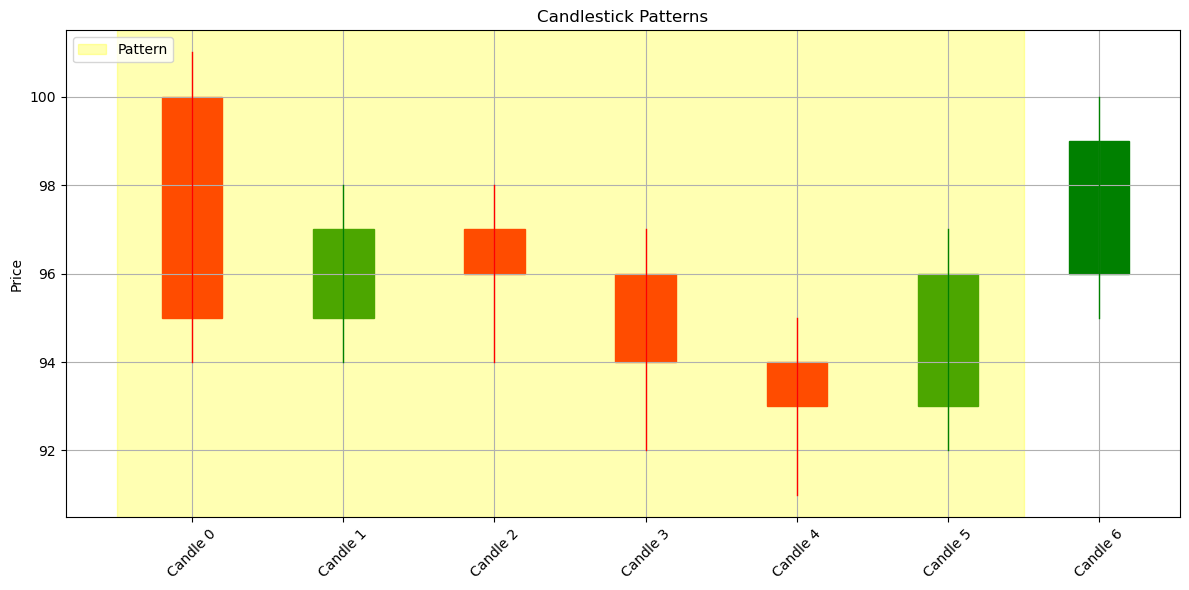

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_patterns(df, patterns):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each candlestick
    for i in range(len(df)):
        # Determine candle color
        color = 'green' if df.loc[i, 'color'] == 'green' else 'red'

        # Plot the candle body
        ax.add_patch(
            patches.Rectangle(
                (i - 0.2, min(df.loc[i, 'open'], df.loc[i, 'close'])),  # Bottom left corner
                0.4,  # Width
                abs(df.loc[i, 'open'] - df.loc[i, 'close']),  # Height
                color=color
            )
        )

        # Plot the candle wicks
        ax.plot(
            [i, i], 
            [df.loc[i, 'low'], df.loc[i, 'high']], 
            color=color, 
            linewidth=1
        )

    # Highlight identified patterns
    for start, end in patterns:
        ax.axvspan(start - 0.5, end + 0.5, color='yellow', alpha=0.3, label='Pattern' if start == patterns[0][0] else "")

    # Add labels and grid
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels([f"Candle {i}" for i in range(len(df))], rotation=45)
    ax.set_ylabel("Price")
    ax.set_title("Candlestick Patterns")
    ax.grid(True)

    # Add legend
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_patterns(df, patterns)

In [ ]:

# root='wss://ws.kite.trade'
import KiteAppUpdate.kiteapp as kt
import pandas as pd
from time import sleep
with open('KiteAppUpdate/enctoken.txt', 'r') as rd:
    token = rd.read()
kite = kt.KiteApp("kite", "FC9764", token)
kws = kite.kws()  # For Websocket


print("Start..")
stock = {1793: 'AARTIIND', 5633: 'ACC',
         6401: 'ADANIENT', 3861249: 'ADANIPORTS'}
# print(list(stock.keys()))

ltp_data = {}


def on_ticks(ws, ticks):
    for symbol in ticks:
        ltp_data[stock[symbol['instrument_token']]] = {
            "ltp": symbol["last_price"], "High": symbol["ohlc"]["high"], "Low": symbol["ohlc"]["low"]}


def on_connect(ws, response):
    ws.subscribe(list(stock.keys()))
    # MODE_FULL , MODE_QUOTE MODE_LTP
    ws.set_mode(ws.MODE_QUOTE, list(stock.keys()))


kws.on_ticks = on_ticks
kws.on_connect = on_connect
kws.connect(threaded=True)
while len(ltp_data.keys()) != len(list(stock.keys())):
    sleep(0.5)
    continue

while True:
    for i in list(stock.values()):
        ltp = ltp_data[i]['ltp']
        high = ltp_data[i]['High']
        print(i, ltp, high)

        if ltp > high:
            print("Yes")
